In [1]:
from sklearn.metrics import fbeta_score, make_scorer, ConfusionMatrixDisplay, classification_report, confusion_matrix
from utils.data_loader import load_split, prepare_features_target
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from utils.learning_curve import learning_curve_with_resampling
from models.manage_models import save_model

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [3]:
train_df = load_split('train', data_dir='dataset/splits')
X_train, y_train = prepare_features_target(train_df, target_col='Fault')

In [4]:
def objective(trial, X, y):
    ratio = float(y.value_counts()[0] / y.value_counts()[1])

    param = {
    "verbosity": 0,
    "objective": "binary:logistic",
    "n_estimators": 1000, # Subimos el techo, el early stopping hará el resto
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
    "max_depth": trial.suggest_int("max_depth", 3, 10),
    
    # --- Nuevos parámetros de regularización ---
    "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
    "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
    "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
    # --------------------------------------------

    "subsample": trial.suggest_float("subsample", 0.6, 1.0),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    "tree_method": "hist",
    "scale_pos_weight": trial.suggest_float("scale_pos_weight", ratio * 0.9, ratio * 1.1),
    "early_stopping_rounds": 50, # Un poco más de margen para encontrar el óptimo
    "eval_metric": "logloss",
    "n_jobs": -1
}

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f2_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**param)
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        preds = model.predict(X_val)
        score = fbeta_score(y_val, preds, beta=2)
        f2_scores.append(score)

    return np.mean(f2_scores)

In [5]:
study = optuna.create_study(direction="maximize", study_name='xgboost_opt')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)

[I 2025-12-22 15:04:19,064] A new study created in memory with name: xgboost_opt
Best trial: 0. Best value: 0.831734:   1%|          | 1/100 [00:17<29:25, 17.84s/it]

[I 2025-12-22 15:04:36,899] Trial 0 finished with value: 0.831733660454919 and parameters: {'learning_rate': 0.014400562479368634, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 3.0329490305234676e-06, 'lambda': 0.5364617649677998, 'alpha': 0.38772275568378795, 'subsample': 0.8525534144908764, 'colsample_bytree': 0.6812603381647075, 'scale_pos_weight': 2.168972464283565}. Best is trial 0 with value: 0.831733660454919.


Best trial: 1. Best value: 0.835509:   2%|▏         | 2/100 [00:41<34:32, 21.15s/it]

[I 2025-12-22 15:05:00,362] Trial 1 finished with value: 0.8355088232677401 and parameters: {'learning_rate': 0.02541002994776132, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 1.09184511900687e-06, 'lambda': 3.9230816691786647, 'alpha': 7.45434051463428e-06, 'subsample': 0.7181991641105008, 'colsample_bytree': 0.7242311506042632, 'scale_pos_weight': 2.0267778601570683}. Best is trial 1 with value: 0.8355088232677401.


Best trial: 2. Best value: 0.838605:   3%|▎         | 3/100 [00:50<25:36, 15.84s/it]

[I 2025-12-22 15:05:09,887] Trial 2 finished with value: 0.8386049590746154 and parameters: {'learning_rate': 0.087072191086259, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 0.012874490563353528, 'lambda': 0.0003305978900096274, 'alpha': 2.5336127491657637e-07, 'subsample': 0.976665240369212, 'colsample_bytree': 0.672701153198093, 'scale_pos_weight': 2.2152303838001495}. Best is trial 2 with value: 0.8386049590746154.


Best trial: 3. Best value: 0.840453:   4%|▍         | 4/100 [01:10<27:44, 17.34s/it]

[I 2025-12-22 15:05:29,525] Trial 3 finished with value: 0.8404526311695711 and parameters: {'learning_rate': 0.024812795517723623, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 0.002009999618373292, 'lambda': 0.02393941309155534, 'alpha': 0.00048532595859129607, 'subsample': 0.702685695740777, 'colsample_bytree': 0.6144161589620846, 'scale_pos_weight': 2.3900593616636385}. Best is trial 3 with value: 0.8404526311695711.


Best trial: 3. Best value: 0.840453:   5%|▌         | 5/100 [01:29<28:09, 17.79s/it]

[I 2025-12-22 15:05:48,095] Trial 4 finished with value: 0.837458172385501 and parameters: {'learning_rate': 0.03862234767434176, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 0.0008645043359005088, 'lambda': 4.8378967070343805e-05, 'alpha': 0.0010033782964328066, 'subsample': 0.9165234496186917, 'colsample_bytree': 0.8034477842779886, 'scale_pos_weight': 2.038114214293732}. Best is trial 3 with value: 0.8404526311695711.


Best trial: 3. Best value: 0.840453:   6%|▌         | 6/100 [01:50<29:35, 18.88s/it]

[I 2025-12-22 15:06:09,121] Trial 5 finished with value: 0.8328813908926987 and parameters: {'learning_rate': 0.01719648075190667, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 2.200253436257138e-05, 'lambda': 0.003790979143469136, 'alpha': 6.386888791315205e-05, 'subsample': 0.6094225878590894, 'colsample_bytree': 0.6951936793928841, 'scale_pos_weight': 2.0683372557389816}. Best is trial 3 with value: 0.8404526311695711.


Best trial: 3. Best value: 0.840453:   7%|▋         | 7/100 [02:08<28:59, 18.71s/it]

[I 2025-12-22 15:06:27,464] Trial 6 finished with value: 0.8344902096286111 and parameters: {'learning_rate': 0.014923616996832046, 'max_depth': 9, 'min_child_weight': 12, 'gamma': 3.5446145139010026e-08, 'lambda': 0.9001307179237699, 'alpha': 7.053683230719935e-08, 'subsample': 0.6078575197224084, 'colsample_bytree': 0.9694181623909606, 'scale_pos_weight': 2.2541957556150893}. Best is trial 3 with value: 0.8404526311695711.


Best trial: 7. Best value: 0.843662:   8%|▊         | 8/100 [02:25<27:50, 18.15s/it]

[I 2025-12-22 15:06:44,431] Trial 7 finished with value: 0.8436624091767453 and parameters: {'learning_rate': 0.022656539066405197, 'max_depth': 9, 'min_child_weight': 19, 'gamma': 0.005561321746190718, 'lambda': 3.603723628485064e-05, 'alpha': 9.855246318673865e-07, 'subsample': 0.6248918231671633, 'colsample_bytree': 0.7828954283953694, 'scale_pos_weight': 2.4162845236511643}. Best is trial 7 with value: 0.8436624091767453.


Best trial: 7. Best value: 0.843662:   9%|▉         | 9/100 [02:38<25:04, 16.53s/it]

[I 2025-12-22 15:06:57,403] Trial 8 finished with value: 0.840502245411983 and parameters: {'learning_rate': 0.053856138533880805, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.10205542218479352, 'lambda': 0.08964448128936517, 'alpha': 8.274263055865271e-05, 'subsample': 0.9310836171870615, 'colsample_bytree': 0.6115189196921244, 'scale_pos_weight': 2.335263774316797}. Best is trial 7 with value: 0.8436624091767453.


Best trial: 7. Best value: 0.843662:  10%|█         | 10/100 [02:52<23:53, 15.92s/it]

[I 2025-12-22 15:07:11,960] Trial 9 finished with value: 0.8407685825823814 and parameters: {'learning_rate': 0.07505462324022792, 'max_depth': 9, 'min_child_weight': 18, 'gamma': 0.00810699792722445, 'lambda': 7.464378519046513e-05, 'alpha': 0.009935861845926952, 'subsample': 0.903363416038641, 'colsample_bytree': 0.6571206022857344, 'scale_pos_weight': 2.4232970555611906}. Best is trial 7 with value: 0.8436624091767453.


Best trial: 7. Best value: 0.843662:  11%|█         | 11/100 [03:00<19:48, 13.35s/it]

[I 2025-12-22 15:07:19,483] Trial 10 finished with value: 0.7924957572254099 and parameters: {'learning_rate': 0.04020304123464939, 'max_depth': 3, 'min_child_weight': 20, 'gamma': 0.863367582526359, 'lambda': 1.4019477651045858e-07, 'alpha': 1.9990756179055765e-06, 'subsample': 0.7511130715047674, 'colsample_bytree': 0.8404848664208473, 'scale_pos_weight': 2.3080514466413873}. Best is trial 7 with value: 0.8436624091767453.


Best trial: 11. Best value: 0.845026:  12%|█▏        | 12/100 [03:12<19:04, 13.01s/it]

[I 2025-12-22 15:07:31,696] Trial 11 finished with value: 0.845025850236037 and parameters: {'learning_rate': 0.08911320585978953, 'max_depth': 7, 'min_child_weight': 20, 'gamma': 0.00023471305019368203, 'lambda': 2.610662397904799e-06, 'alpha': 0.05854494206301575, 'subsample': 0.8345502072162738, 'colsample_bytree': 0.9113645482771304, 'scale_pos_weight': 2.433798968418168}. Best is trial 11 with value: 0.845025850236037.


Best trial: 11. Best value: 0.845026:  13%|█▎        | 13/100 [03:25<18:44, 12.92s/it]

[I 2025-12-22 15:07:44,427] Trial 12 finished with value: 0.8099278552975766 and parameters: {'learning_rate': 0.01053349977804768, 'max_depth': 7, 'min_child_weight': 16, 'gamma': 0.00018673615629689877, 'lambda': 6.245794424304213e-07, 'alpha': 8.753412185115316, 'subsample': 0.8060869225844334, 'colsample_bytree': 0.9087283760726602, 'scale_pos_weight': 2.443345679043625}. Best is trial 11 with value: 0.845025850236037.


Best trial: 13. Best value: 0.846335:  14%|█▍        | 14/100 [03:36<17:38, 12.30s/it]

[I 2025-12-22 15:07:55,297] Trial 13 finished with value: 0.8463351557943468 and parameters: {'learning_rate': 0.06162152569141622, 'max_depth': 6, 'min_child_weight': 20, 'gamma': 0.000122530247216155, 'lambda': 2.5056001645144496e-06, 'alpha': 0.018894943616132264, 'subsample': 0.8191041474404933, 'colsample_bytree': 0.8774245977090022, 'scale_pos_weight': 2.3639506416550327}. Best is trial 13 with value: 0.8463351557943468.


Best trial: 13. Best value: 0.846335:  15%|█▌        | 15/100 [03:45<16:18, 11.51s/it]

[I 2025-12-22 15:08:04,964] Trial 14 finished with value: 0.8411527002840732 and parameters: {'learning_rate': 0.06372188454416701, 'max_depth': 5, 'min_child_weight': 13, 'gamma': 2.6339511490985857e-05, 'lambda': 1.4094015304809113e-08, 'alpha': 0.03822372739369444, 'subsample': 0.8149199910172511, 'colsample_bytree': 0.906381162929308, 'scale_pos_weight': 2.3401067681195955}. Best is trial 13 with value: 0.8463351557943468.


Best trial: 15. Best value: 0.846801:  16%|█▌        | 16/100 [03:56<15:54, 11.36s/it]

[I 2025-12-22 15:08:15,980] Trial 15 finished with value: 0.8468010878908103 and parameters: {'learning_rate': 0.09022034831313147, 'max_depth': 6, 'min_child_weight': 17, 'gamma': 6.812811219256374e-07, 'lambda': 2.7935033526334323e-06, 'alpha': 0.4345347838271185, 'subsample': 0.854313353070553, 'colsample_bytree': 0.9923805029029803, 'scale_pos_weight': 2.368838742571186}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  17%|█▋        | 17/100 [04:06<15:03, 10.88s/it]

[I 2025-12-22 15:08:25,755] Trial 16 finished with value: 0.8363470856404103 and parameters: {'learning_rate': 0.04975976780025397, 'max_depth': 5, 'min_child_weight': 16, 'gamma': 4.9803567974376084e-08, 'lambda': 2.945277266963771e-06, 'alpha': 2.8134762714843884, 'subsample': 0.7600303532826631, 'colsample_bytree': 0.9978247710602299, 'scale_pos_weight': 2.275948085797309}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  18%|█▊        | 18/100 [04:17<14:54, 10.91s/it]

[I 2025-12-22 15:08:36,741] Trial 17 finished with value: 0.8462994515863048 and parameters: {'learning_rate': 0.09865101861732915, 'max_depth': 6, 'min_child_weight': 17, 'gamma': 5.408663778445326e-07, 'lambda': 2.7345571496185463e-08, 'alpha': 0.4783258442822438, 'subsample': 0.8746933702720511, 'colsample_bytree': 0.8647955669059416, 'scale_pos_weight': 2.3597463644299035}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  19%|█▉        | 19/100 [04:24<13:14,  9.81s/it]

[I 2025-12-22 15:08:43,987] Trial 18 finished with value: 0.8054474448919924 and parameters: {'learning_rate': 0.06730063177313951, 'max_depth': 3, 'min_child_weight': 14, 'gamma': 1.1744993682564983e-05, 'lambda': 8.46746529946075e-06, 'alpha': 0.005156469392352424, 'subsample': 0.9819237005555829, 'colsample_bytree': 0.9415211124206951, 'scale_pos_weight': 2.1740188014072577}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  20%|██        | 20/100 [04:35<13:33, 10.16s/it]

[I 2025-12-22 15:08:54,969] Trial 19 finished with value: 0.8425254322636508 and parameters: {'learning_rate': 0.0503690551635474, 'max_depth': 6, 'min_child_weight': 11, 'gamma': 3.1777708805217924e-07, 'lambda': 2.4413497711783356e-07, 'alpha': 0.42337164792425347, 'subsample': 0.7849954018035349, 'colsample_bytree': 0.9965279531062715, 'scale_pos_weight': 2.2930750201879984}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  21%|██        | 21/100 [04:44<12:39,  9.61s/it]

[I 2025-12-22 15:09:03,293] Trial 20 finished with value: 0.8081676557613701 and parameters: {'learning_rate': 0.03562850727499335, 'max_depth': 4, 'min_child_weight': 18, 'gamma': 1.3610367963453839e-07, 'lambda': 0.0009450339654787796, 'alpha': 0.002717325478904355, 'subsample': 0.6691780989622036, 'colsample_bytree': 0.7615804095635147, 'scale_pos_weight': 2.373744921325437}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  22%|██▏       | 22/100 [04:54<12:53,  9.92s/it]

[I 2025-12-22 15:09:13,930] Trial 21 finished with value: 0.8461974936657771 and parameters: {'learning_rate': 0.09975657710401209, 'max_depth': 6, 'min_child_weight': 17, 'gamma': 2.9708800031870357e-06, 'lambda': 2.42747851860112e-08, 'alpha': 0.30912934845809364, 'subsample': 0.872659923615028, 'colsample_bytree': 0.852508645466321, 'scale_pos_weight': 2.3635372980973623}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  23%|██▎       | 23/100 [05:05<13:04, 10.19s/it]

[I 2025-12-22 15:09:24,743] Trial 22 finished with value: 0.8453557437885199 and parameters: {'learning_rate': 0.07805382562566072, 'max_depth': 6, 'min_child_weight': 18, 'gamma': 5.251689222976997e-07, 'lambda': 6.153820413092864e-08, 'alpha': 1.628104490745805, 'subsample': 0.8816558272289209, 'colsample_bytree': 0.858774585277308, 'scale_pos_weight': 2.328799836719085}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  24%|██▍       | 24/100 [05:17<13:42, 10.82s/it]

[I 2025-12-22 15:09:37,039] Trial 23 finished with value: 0.8443221811233474 and parameters: {'learning_rate': 0.09926430978493325, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 4.9887534124302674e-05, 'lambda': 1.0084343295660101e-06, 'alpha': 0.04235537201317953, 'subsample': 0.9493282111087264, 'colsample_bytree': 0.8826656223775888, 'scale_pos_weight': 2.3849658756824352}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  25%|██▌       | 25/100 [05:26<12:35, 10.07s/it]

[I 2025-12-22 15:09:45,356] Trial 24 finished with value: 0.8252009799506134 and parameters: {'learning_rate': 0.06082064174613901, 'max_depth': 4, 'min_child_weight': 20, 'gamma': 1.1578264905830273e-08, 'lambda': 1.3688414333711592e-05, 'alpha': 0.1342784525790435, 'subsample': 0.850024100868564, 'colsample_bytree': 0.9440024423243024, 'scale_pos_weight': 2.2379513801520408}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  26%|██▌       | 26/100 [05:36<12:37, 10.24s/it]

[I 2025-12-22 15:09:56,000] Trial 25 finished with value: 0.8452042947549538 and parameters: {'learning_rate': 0.07453139009453276, 'max_depth': 6, 'min_child_weight': 16, 'gamma': 7.838863027333134e-06, 'lambda': 2.1527069635004442e-07, 'alpha': 0.013638349048139582, 'subsample': 0.8857612516980877, 'colsample_bytree': 0.8165149689563314, 'scale_pos_weight': 2.3569978748176728}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  27%|██▋       | 27/100 [05:54<14:59, 12.32s/it]

[I 2025-12-22 15:10:13,181] Trial 26 finished with value: 0.8433719615505556 and parameters: {'learning_rate': 0.045249226533197434, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 1.897069702725585e-06, 'lambda': 1.1416192202729191e-08, 'alpha': 1.6491862412774168, 'subsample': 0.7844386624164642, 'colsample_bytree': 0.7507965151024182, 'scale_pos_weight': 2.402802985597807}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  28%|██▊       | 28/100 [06:03<13:53, 11.58s/it]

[I 2025-12-22 15:10:23,032] Trial 27 finished with value: 0.8435679888718861 and parameters: {'learning_rate': 0.08495250522971694, 'max_depth': 5, 'min_child_weight': 17, 'gamma': 0.0005541181589803341, 'lambda': 1.2390272709699113e-06, 'alpha': 9.368027130841435, 'subsample': 0.8283504999435927, 'colsample_bytree': 0.9529221960747511, 'scale_pos_weight': 2.2761046554749}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  29%|██▉       | 29/100 [06:12<12:31, 10.58s/it]

[I 2025-12-22 15:10:31,286] Trial 28 finished with value: 0.8217522675292551 and parameters: {'learning_rate': 0.05834155168353859, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 9.504137969498341e-05, 'lambda': 6.791483635612394e-06, 'alpha': 0.6757224288087893, 'subsample': 0.9470997015917826, 'colsample_bytree': 0.8795045004844446, 'scale_pos_weight': 2.200705945294375}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  30%|███       | 30/100 [06:24<13:00, 11.15s/it]

[I 2025-12-22 15:10:43,756] Trial 29 finished with value: 0.8400929612295343 and parameters: {'learning_rate': 0.06968693076803845, 'max_depth': 7, 'min_child_weight': 19, 'gamma': 9.789896550172542e-08, 'lambda': 4.6642742015742405e-08, 'alpha': 0.13384439621152952, 'subsample': 0.8610509664122588, 'colsample_bytree': 0.9297204324296001, 'scale_pos_weight': 2.088983825431236}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  31%|███       | 31/100 [06:38<13:52, 12.07s/it]

[I 2025-12-22 15:10:57,973] Trial 30 finished with value: 0.8446495160646442 and parameters: {'learning_rate': 0.03005770061132112, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 4.049345551973032e-06, 'lambda': 0.0001829696807760561, 'alpha': 0.0015030548136346052, 'subsample': 0.8444596563681087, 'colsample_bytree': 0.8322780167854663, 'scale_pos_weight': 2.3026446502934768}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  32%|███▏      | 32/100 [06:49<13:15, 11.70s/it]

[I 2025-12-22 15:11:08,794] Trial 31 finished with value: 0.8450325192754653 and parameters: {'learning_rate': 0.09471656653543022, 'max_depth': 6, 'min_child_weight': 17, 'gamma': 6.524256325846533e-07, 'lambda': 4.1060161339179104e-08, 'alpha': 0.1802333441531401, 'subsample': 0.8698995513622826, 'colsample_bytree': 0.8695996180933873, 'scale_pos_weight': 2.362550787455952}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  33%|███▎      | 33/100 [07:00<12:48, 11.48s/it]

[I 2025-12-22 15:11:19,757] Trial 32 finished with value: 0.8448322384828406 and parameters: {'learning_rate': 0.09640430914458835, 'max_depth': 6, 'min_child_weight': 17, 'gamma': 3.837473032808277e-06, 'lambda': 4.317125785022399e-07, 'alpha': 0.9619412323794901, 'subsample': 0.8985608864144103, 'colsample_bytree': 0.8503528244524471, 'scale_pos_weight': 2.3286182356033147}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  34%|███▍      | 34/100 [07:10<12:00, 10.92s/it]

[I 2025-12-22 15:11:29,367] Trial 33 finished with value: 0.8435727985707994 and parameters: {'learning_rate': 0.07966095225368049, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 1.3314517696048092e-06, 'lambda': 7.498600448956856e-08, 'alpha': 0.020150333838416978, 'subsample': 0.8633581047507403, 'colsample_bytree': 0.7810207137320244, 'scale_pos_weight': 2.3580106816286204}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  35%|███▌      | 35/100 [07:21<11:49, 10.92s/it]

[I 2025-12-22 15:11:40,290] Trial 34 finished with value: 0.8463427892572449 and parameters: {'learning_rate': 0.08455522120029323, 'max_depth': 6, 'min_child_weight': 19, 'gamma': 2.3400072227693282e-07, 'lambda': 1.765764173786026e-08, 'alpha': 0.2675423874358916, 'subsample': 0.7631789978863783, 'colsample_bytree': 0.8884139974382687, 'scale_pos_weight': 2.40042001768992}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 15. Best value: 0.846801:  36%|███▌      | 36/100 [07:34<12:18, 11.53s/it]

[I 2025-12-22 15:11:53,257] Trial 35 finished with value: 0.8467743123149042 and parameters: {'learning_rate': 0.08292063496218029, 'max_depth': 7, 'min_child_weight': 19, 'gamma': 2.514444378489231e-07, 'lambda': 1.0283974511123931e-08, 'alpha': 4.114519840434461, 'subsample': 0.7299941223380317, 'colsample_bytree': 0.971740495291396, 'scale_pos_weight': 2.3917892808487764}. Best is trial 15 with value: 0.8468010878908103.


Best trial: 36. Best value: 0.848236:  37%|███▋      | 37/100 [07:47<12:33, 11.96s/it]

[I 2025-12-22 15:12:06,201] Trial 36 finished with value: 0.8482360631690549 and parameters: {'learning_rate': 0.058031767992702155, 'max_depth': 7, 'min_child_weight': 19, 'gamma': 1.1676878437175626e-08, 'lambda': 0.0015215126495683163, 'alpha': 4.373303328830448, 'subsample': 0.717379390448101, 'colsample_bytree': 0.9733383615922252, 'scale_pos_weight': 2.406126197134347}. Best is trial 36 with value: 0.8482360631690549.


Best trial: 36. Best value: 0.848236:  38%|███▊      | 38/100 [08:00<12:39, 12.25s/it]

[I 2025-12-22 15:12:19,152] Trial 37 finished with value: 0.845969185400301 and parameters: {'learning_rate': 0.0808975310449965, 'max_depth': 7, 'min_child_weight': 19, 'gamma': 1.9057609411316015e-08, 'lambda': 0.000969786414936155, 'alpha': 4.230932869322705, 'subsample': 0.70527525193554, 'colsample_bytree': 0.971648758267311, 'scale_pos_weight': 2.4082190032810797}. Best is trial 36 with value: 0.8482360631690549.


Best trial: 38. Best value: 0.848762:  39%|███▉      | 39/100 [08:14<13:07, 12.92s/it]

[I 2025-12-22 15:12:33,611] Trial 38 finished with value: 0.8487621263353196 and parameters: {'learning_rate': 0.044135112877006846, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 1.9768669817351394e-07, 'lambda': 0.010166568221533898, 'alpha': 3.6677512920911743, 'subsample': 0.7332500471594041, 'colsample_bytree': 0.974015553693246, 'scale_pos_weight': 2.4431507924483897}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  40%|████      | 40/100 [08:29<13:33, 13.56s/it]

[I 2025-12-22 15:12:48,659] Trial 39 finished with value: 0.8417063292380789 and parameters: {'learning_rate': 0.0439640632262905, 'max_depth': 8, 'min_child_weight': 15, 'gamma': 3.726174824806606e-08, 'lambda': 0.03970665578422573, 'alpha': 5.0694581822333165, 'subsample': 0.7288814356844328, 'colsample_bytree': 0.9744909084900095, 'scale_pos_weight': 2.1321347449543078}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  41%|████      | 41/100 [08:47<14:42, 14.96s/it]

[I 2025-12-22 15:13:06,891] Trial 40 finished with value: 0.8464780742098036 and parameters: {'learning_rate': 0.029186916600357812, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 8.635486201003938e-08, 'lambda': 0.006710621236591403, 'alpha': 2.163985626520382, 'subsample': 0.6645885768510758, 'colsample_bytree': 0.9799925826187388, 'scale_pos_weight': 2.441052155809814}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  42%|████▏     | 42/100 [09:06<15:29, 16.03s/it]

[I 2025-12-22 15:13:25,424] Trial 41 finished with value: 0.8468265697564723 and parameters: {'learning_rate': 0.029496717064771177, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 5.483298545437944e-08, 'lambda': 0.007237359341552504, 'alpha': 2.107949718053195, 'subsample': 0.6595673089041953, 'colsample_bytree': 0.9748176607417046, 'scale_pos_weight': 2.442765470043861}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  43%|████▎     | 43/100 [09:25<16:02, 16.88s/it]

[I 2025-12-22 15:13:44,286] Trial 42 finished with value: 0.8454186017123282 and parameters: {'learning_rate': 0.022526947350483884, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 1.0574977205022483e-08, 'lambda': 0.005235877618806174, 'alpha': 0.9401740304628975, 'subsample': 0.6732832205442876, 'colsample_bytree': 0.9565658213783692, 'scale_pos_weight': 2.447302850721336}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  44%|████▍     | 44/100 [09:40<15:22, 16.48s/it]

[I 2025-12-22 15:13:59,826] Trial 43 finished with value: 0.8415691586190699 and parameters: {'learning_rate': 0.01878089303650808, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 1.772466603733691e-07, 'lambda': 0.8379741281543646, 'alpha': 0.00011404362403711329, 'subsample': 0.732213197755652, 'colsample_bytree': 0.9266386445890021, 'scale_pos_weight': 2.4121437678960596}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  45%|████▌     | 45/100 [10:05<17:18, 18.88s/it]

[I 2025-12-22 15:14:24,298] Trial 44 finished with value: 0.8462707121720872 and parameters: {'learning_rate': 0.03397530230650201, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 3.10981549962037e-08, 'lambda': 0.25330325425653444, 'alpha': 8.825400725356952, 'subsample': 0.6969418340471838, 'colsample_bytree': 0.985855827125975, 'scale_pos_weight': 2.3859869331628665}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  46%|████▌     | 46/100 [10:19<15:43, 17.47s/it]

[I 2025-12-22 15:14:38,478] Trial 45 finished with value: 0.843345671823303 and parameters: {'learning_rate': 0.026045109107459125, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 5.1941181137797884e-08, 'lambda': 0.021073238136151626, 'alpha': 3.1586455273299596, 'subsample': 0.6346983198675357, 'colsample_bytree': 0.9646019354521917, 'scale_pos_weight': 2.426274975255129}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  47%|████▋     | 47/100 [10:33<14:39, 16.60s/it]

[I 2025-12-22 15:14:53,054] Trial 46 finished with value: 0.8476543747954594 and parameters: {'learning_rate': 0.03925213638749608, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 1.9869702926460053e-08, 'lambda': 0.0012745082780257597, 'alpha': 3.722493294216102e-08, 'subsample': 0.6461807452807021, 'colsample_bytree': 0.930462607997087, 'scale_pos_weight': 2.4204309811504525}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  48%|████▊     | 48/100 [10:52<14:56, 17.25s/it]

[I 2025-12-22 15:15:11,810] Trial 47 finished with value: 0.842959154055303 and parameters: {'learning_rate': 0.03977057733926269, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 2.2023263749456018e-08, 'lambda': 0.0015109254328674884, 'alpha': 2.4704553242330443e-08, 'subsample': 0.6421791097725834, 'colsample_bytree': 0.9985527056040243, 'scale_pos_weight': 2.4287798889453205}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  49%|████▉     | 49/100 [11:07<14:08, 16.63s/it]

[I 2025-12-22 15:15:27,007] Trial 48 finished with value: 0.8480417707038844 and parameters: {'learning_rate': 0.04449933560353685, 'max_depth': 8, 'min_child_weight': 12, 'gamma': 5.472745133348018e-08, 'lambda': 0.00034006449143891094, 'alpha': 1.4024015254925908e-05, 'subsample': 0.6899650622969233, 'colsample_bytree': 0.9265192648212248, 'scale_pos_weight': 2.448209998297908}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  50%|█████     | 50/100 [11:22<13:26, 16.14s/it]

[I 2025-12-22 15:15:41,987] Trial 49 finished with value: 0.8468606572346751 and parameters: {'learning_rate': 0.044084183015173244, 'max_depth': 8, 'min_child_weight': 12, 'gamma': 7.5629953534418e-08, 'lambda': 0.0003720465146718989, 'alpha': 1.5609524109418282e-05, 'subsample': 0.6838209164323259, 'colsample_bytree': 0.9283541800973518, 'scale_pos_weight': 2.422784146289695}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  51%|█████     | 51/100 [11:37<12:54, 15.80s/it]

[I 2025-12-22 15:15:57,010] Trial 50 finished with value: 0.8462506416510294 and parameters: {'learning_rate': 0.04430211580981571, 'max_depth': 8, 'min_child_weight': 11, 'gamma': 8.991243659419227e-08, 'lambda': 0.00023952413824953074, 'alpha': 1.3345533339356295e-05, 'subsample': 0.687785827623187, 'colsample_bytree': 0.9003188285650275, 'scale_pos_weight': 2.4188193843688586}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  52%|█████▏    | 52/100 [11:54<12:49, 16.02s/it]

[I 2025-12-22 15:16:13,551] Trial 51 finished with value: 0.8363981298180972 and parameters: {'learning_rate': 0.0352590373783656, 'max_depth': 9, 'min_child_weight': 13, 'gamma': 1.014977135503439e-08, 'lambda': 0.002141324530196728, 'alpha': 2.6945610113697536e-07, 'subsample': 0.6453563569387034, 'colsample_bytree': 0.9276923229134696, 'scale_pos_weight': 2.0056905390080035}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  53%|█████▎    | 53/100 [12:09<12:14, 15.63s/it]

[I 2025-12-22 15:16:28,268] Trial 52 finished with value: 0.8454014171643902 and parameters: {'learning_rate': 0.05162846581573667, 'max_depth': 8, 'min_child_weight': 12, 'gamma': 5.9220645620463255e-08, 'lambda': 0.0004524133806029091, 'alpha': 1.255840137707369e-05, 'subsample': 0.6102558396100193, 'colsample_bytree': 0.918937614888859, 'scale_pos_weight': 2.4473512693091855}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  54%|█████▍    | 54/100 [12:26<12:21, 16.12s/it]

[I 2025-12-22 15:16:45,513] Trial 53 finished with value: 0.8429360098251075 and parameters: {'learning_rate': 0.0565849939211809, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 2.1529028825702662e-08, 'lambda': 0.00010070882228676191, 'alpha': 1.08796304386386e-06, 'subsample': 0.7101557215349165, 'colsample_bytree': 0.9379025591343506, 'scale_pos_weight': 2.425838554386721}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  55%|█████▌    | 55/100 [12:43<12:20, 16.45s/it]

[I 2025-12-22 15:17:02,739] Trial 54 finished with value: 0.8440084941521677 and parameters: {'learning_rate': 0.038175354332113665, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.021553109562281045, 'lambda': 0.01084033361539039, 'alpha': 0.00032980794966132944, 'subsample': 0.6557285582688119, 'colsample_bytree': 0.9532839706421087, 'scale_pos_weight': 2.4040120565296506}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  56%|█████▌    | 56/100 [13:03<12:53, 17.58s/it]

[I 2025-12-22 15:17:22,948] Trial 55 finished with value: 0.8417214173877614 and parameters: {'learning_rate': 0.04602732078972609, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 3.490939576926273e-08, 'lambda': 0.0006327265804606339, 'alpha': 3.6555616645972633e-06, 'subsample': 0.6860244545208799, 'colsample_bytree': 0.8976168706628923, 'scale_pos_weight': 2.3826642967010225}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  57%|█████▋    | 57/100 [13:18<12:03, 16.83s/it]

[I 2025-12-22 15:17:38,026] Trial 56 finished with value: 0.8442519069767551 and parameters: {'learning_rate': 0.03222851144001774, 'max_depth': 8, 'min_child_weight': 12, 'gamma': 1.2539860308269232e-07, 'lambda': 4.265967846685059, 'alpha': 8.283197412352331e-08, 'subsample': 0.7476211164978261, 'colsample_bytree': 0.6852532061528889, 'scale_pos_weight': 2.4263079979407345}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  58%|█████▊    | 58/100 [13:32<11:00, 15.72s/it]

[I 2025-12-22 15:17:51,165] Trial 57 finished with value: 0.8420098311965518 and parameters: {'learning_rate': 0.027356123374513534, 'max_depth': 7, 'min_child_weight': 20, 'gamma': 1.693718098875401e-08, 'lambda': 0.0026855468725187274, 'alpha': 6.817580267558938e-05, 'subsample': 0.6230645412461584, 'colsample_bytree': 0.9454538449553571, 'scale_pos_weight': 2.436164211841964}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  59%|█████▉    | 59/100 [13:49<11:05, 16.24s/it]

[I 2025-12-22 15:18:08,607] Trial 58 finished with value: 0.8439329531656108 and parameters: {'learning_rate': 0.040747699941607055, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 3.3175017015762206e-07, 'lambda': 2.725128840071128e-05, 'alpha': 3.9835387457543214e-07, 'subsample': 0.688146628902231, 'colsample_bytree': 0.9607377077802679, 'scale_pos_weight': 2.4135736586265026}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  60%|██████    | 60/100 [14:04<10:29, 15.74s/it]

[I 2025-12-22 15:18:23,172] Trial 59 finished with value: 0.8457006012760748 and parameters: {'learning_rate': 0.048533422250738104, 'max_depth': 8, 'min_child_weight': 18, 'gamma': 5.478688646500924e-08, 'lambda': 0.012835838344411833, 'alpha': 1.3453034728999798e-08, 'subsample': 0.7167557303378305, 'colsample_bytree': 0.9163052427325478, 'scale_pos_weight': 2.343283428544622}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  61%|██████    | 61/100 [14:17<09:44, 14.98s/it]

[I 2025-12-22 15:18:36,387] Trial 60 finished with value: 0.8358818419617077 and parameters: {'learning_rate': 0.023281574634574805, 'max_depth': 7, 'min_child_weight': 13, 'gamma': 0.7675456244461614, 'lambda': 0.0626643316271486, 'alpha': 2.5632556046915988e-05, 'subsample': 0.6781239100488168, 'colsample_bytree': 0.7132238009665322, 'scale_pos_weight': 2.3990542794637335}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  62%|██████▏   | 62/100 [14:30<09:06, 14.37s/it]

[I 2025-12-22 15:18:49,346] Trial 61 finished with value: 0.8462844853331273 and parameters: {'learning_rate': 0.05556493760673432, 'max_depth': 7, 'min_child_weight': 16, 'gamma': 7.799761536003454e-07, 'lambda': 0.00011754286859593363, 'alpha': 0.00015402825528964385, 'subsample': 0.6530628662305612, 'colsample_bytree': 0.9883346783523098, 'scale_pos_weight': 2.3781523608939574}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  63%|██████▎   | 63/100 [14:47<09:24, 15.27s/it]

[I 2025-12-22 15:19:06,694] Trial 62 finished with value: 0.8473964578751343 and parameters: {'learning_rate': 0.04208227335846858, 'max_depth': 9, 'min_child_weight': 18, 'gamma': 1.5342979298016956e-07, 'lambda': 0.14765069636400355, 'alpha': 3.263042785020402e-05, 'subsample': 0.784659755192641, 'colsample_bytree': 0.9918035351518766, 'scale_pos_weight': 2.448108331829784}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  64%|██████▍   | 64/100 [15:03<09:16, 15.47s/it]

[I 2025-12-22 15:19:22,647] Trial 63 finished with value: 0.8446418799028402 and parameters: {'learning_rate': 0.03734219967200423, 'max_depth': 9, 'min_child_weight': 20, 'gamma': 1.8610726569165092e-07, 'lambda': 0.25974310959041663, 'alpha': 3.689164734183096e-05, 'subsample': 0.7870676783669394, 'colsample_bytree': 0.6483972847761611, 'scale_pos_weight': 2.44402353406814}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  65%|██████▌   | 65/100 [15:19<09:08, 15.69s/it]

[I 2025-12-22 15:19:38,830] Trial 64 finished with value: 0.846791277078341 and parameters: {'learning_rate': 0.04210981375315163, 'max_depth': 9, 'min_child_weight': 18, 'gamma': 4.2793860607511227e-07, 'lambda': 0.09843687895564729, 'alpha': 4.316211230277198e-06, 'subsample': 0.7455861870402245, 'colsample_bytree': 0.9792123408405911, 'scale_pos_weight': 2.4187912263969986}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  66%|██████▌   | 66/100 [15:38<09:21, 16.51s/it]

[I 2025-12-22 15:19:57,264] Trial 65 finished with value: 0.8472688792623554 and parameters: {'learning_rate': 0.03267941038906844, 'max_depth': 10, 'min_child_weight': 19, 'gamma': 7.098517197577953e-08, 'lambda': 0.004738434030571062, 'alpha': 0.000998908869739539, 'subsample': 0.7718258910298424, 'colsample_bytree': 0.9459660811568862, 'scale_pos_weight': 2.4348848244235817}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  67%|██████▋   | 67/100 [15:56<09:20, 16.99s/it]

[I 2025-12-22 15:20:15,391] Trial 66 finished with value: 0.84756692013235 and parameters: {'learning_rate': 0.03278192203803972, 'max_depth': 10, 'min_child_weight': 19, 'gamma': 8.985328550685854e-08, 'lambda': 2.1677504329786985, 'alpha': 0.0007620138921664133, 'subsample': 0.7611627572106975, 'colsample_bytree': 0.9355227135042258, 'scale_pos_weight': 2.430419128980352}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  68%|██████▊   | 68/100 [16:14<09:15, 17.36s/it]

[I 2025-12-22 15:20:33,617] Trial 67 finished with value: 0.8466682915517246 and parameters: {'learning_rate': 0.032926236123683374, 'max_depth': 10, 'min_child_weight': 19, 'gamma': 2.6373762893860914e-08, 'lambda': 2.1855951864943783, 'alpha': 0.0008028525062408815, 'subsample': 0.7752795448494129, 'colsample_bytree': 0.9404436450095152, 'scale_pos_weight': 2.393094266844007}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  69%|██████▉   | 69/100 [16:32<09:03, 17.53s/it]

[I 2025-12-22 15:20:51,526] Trial 68 finished with value: 0.8469712792735471 and parameters: {'learning_rate': 0.0360392938794402, 'max_depth': 10, 'min_child_weight': 20, 'gamma': 1.5675770727279178e-06, 'lambda': 2.081315829505335, 'alpha': 0.00018763580151329943, 'subsample': 0.8041039391717867, 'colsample_bytree': 0.9595919513136429, 'scale_pos_weight': 2.4329838410035602}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  70%|███████   | 70/100 [16:50<08:45, 17.53s/it]

[I 2025-12-22 15:21:09,067] Trial 69 finished with value: 0.8428619544916038 and parameters: {'learning_rate': 0.050013095415079256, 'max_depth': 10, 'min_child_weight': 18, 'gamma': 1.787686810582571e-07, 'lambda': 0.2714848964282846, 'alpha': 0.0003318559664509511, 'subsample': 0.7552781024371163, 'colsample_bytree': 0.9127588541031892, 'scale_pos_weight': 2.4116664452792653}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  71%|███████   | 71/100 [17:09<08:41, 17.99s/it]

[I 2025-12-22 15:21:28,130] Trial 70 finished with value: 0.8439487093677688 and parameters: {'learning_rate': 0.04715920751991034, 'max_depth': 10, 'min_child_weight': 19, 'gamma': 1.6445233534328683e-08, 'lambda': 0.003827297963303538, 'alpha': 0.005739108337801248, 'subsample': 0.7726385362341287, 'colsample_bytree': 0.9998689368924901, 'scale_pos_weight': 2.346345598533162}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  72%|███████▏  | 72/100 [17:26<08:21, 17.92s/it]

[I 2025-12-22 15:21:45,886] Trial 71 finished with value: 0.8469593359285437 and parameters: {'learning_rate': 0.03601144589343325, 'max_depth': 10, 'min_child_weight': 20, 'gamma': 1.5030180992496606e-06, 'lambda': 1.1362764877703986, 'alpha': 0.0007960191114080308, 'subsample': 0.8174412390723506, 'colsample_bytree': 0.9595670119434939, 'scale_pos_weight': 2.432265512412184}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  73%|███████▎  | 73/100 [17:45<08:06, 18.01s/it]

[I 2025-12-22 15:22:04,120] Trial 72 finished with value: 0.8475528477117436 and parameters: {'learning_rate': 0.0314799321641265, 'max_depth': 10, 'min_child_weight': 19, 'gamma': 1.2119767603090867e-07, 'lambda': 1.430680170116113, 'alpha': 0.001778953336200759, 'subsample': 0.8015652349055296, 'colsample_bytree': 0.9516507788708407, 'scale_pos_weight': 2.4481725073933296}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 38. Best value: 0.848762:  74%|███████▍  | 74/100 [18:03<07:47, 18.00s/it]

[I 2025-12-22 15:22:22,075] Trial 73 finished with value: 0.8470540804140173 and parameters: {'learning_rate': 0.031028999861462566, 'max_depth': 10, 'min_child_weight': 19, 'gamma': 1.1506568631600076e-07, 'lambda': 0.14550450678169685, 'alpha': 0.002369311603338891, 'subsample': 0.7933932126144723, 'colsample_bytree': 0.9467666430730702, 'scale_pos_weight': 2.40684367276489}. Best is trial 38 with value: 0.8487621263353196.


Best trial: 74. Best value: 0.848856:  75%|███████▌  | 75/100 [18:21<07:32, 18.08s/it]

[I 2025-12-22 15:22:40,361] Trial 74 finished with value: 0.8488555046107453 and parameters: {'learning_rate': 0.027347143877563065, 'max_depth': 10, 'min_child_weight': 17, 'gamma': 3.459371333534247e-07, 'lambda': 7.7397181128257975, 'alpha': 0.006742040731588818, 'subsample': 0.9970066974680117, 'colsample_bytree': 0.9864034240486679, 'scale_pos_weight': 2.4381093493898205}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  76%|███████▌  | 76/100 [18:38<07:06, 17.78s/it]

[I 2025-12-22 15:22:57,419] Trial 75 finished with value: 0.847488071973616 and parameters: {'learning_rate': 0.02740413043539264, 'max_depth': 9, 'min_child_weight': 17, 'gamma': 4.574728319199123e-07, 'lambda': 6.931962664736422, 'alpha': 0.005815731939274142, 'subsample': 0.7396313863695193, 'colsample_bytree': 0.9853053469720013, 'scale_pos_weight': 2.446803625590954}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  77%|███████▋  | 77/100 [18:57<06:56, 18.09s/it]

[I 2025-12-22 15:23:16,233] Trial 76 finished with value: 0.8469687684168798 and parameters: {'learning_rate': 0.027649973203558633, 'max_depth': 10, 'min_child_weight': 17, 'gamma': 4.180432295371659e-07, 'lambda': 5.967641873869313, 'alpha': 0.0043138331493054105, 'subsample': 0.7373628824083217, 'colsample_bytree': 0.9674647776560992, 'scale_pos_weight': 2.395347030008883}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  78%|███████▊  | 78/100 [19:14<06:30, 17.77s/it]

[I 2025-12-22 15:23:33,260] Trial 77 finished with value: 0.8439603710903016 and parameters: {'learning_rate': 0.020703254311483777, 'max_depth': 9, 'min_child_weight': 16, 'gamma': 1.0256928100830117e-06, 'lambda': 2.3227101661129845, 'alpha': 0.010657677857598292, 'subsample': 0.9925452112512495, 'colsample_bytree': 0.9826744447888753, 'scale_pos_weight': 2.420297035194185}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  79%|███████▉  | 79/100 [19:30<06:06, 17.43s/it]

[I 2025-12-22 15:23:49,897] Trial 78 finished with value: 0.8462272764514974 and parameters: {'learning_rate': 0.024965585747375577, 'max_depth': 9, 'min_child_weight': 18, 'gamma': 2.7776173582160996e-07, 'lambda': 0.5589960922304683, 'alpha': 0.036309042013596596, 'subsample': 0.7198242795571979, 'colsample_bytree': 0.8929319974241056, 'scale_pos_weight': 2.4347335010211633}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  80%|████████  | 80/100 [19:54<06:26, 19.31s/it]

[I 2025-12-22 15:24:13,588] Trial 79 finished with value: 0.8412643282817598 and parameters: {'learning_rate': 0.027910732411176337, 'max_depth': 10, 'min_child_weight': 17, 'gamma': 0.0023579204456692236, 'lambda': 8.573544389269964, 'alpha': 0.0019698698062782607, 'subsample': 0.9326526453254664, 'colsample_bytree': 0.9671545626386936, 'scale_pos_weight': 2.1501828412053343}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  81%|████████  | 81/100 [20:10<05:50, 18.42s/it]

[I 2025-12-22 15:24:29,949] Trial 80 finished with value: 0.8450421908938924 and parameters: {'learning_rate': 0.0666484440279949, 'max_depth': 8, 'min_child_weight': 16, 'gamma': 1.4146279559525159e-08, 'lambda': 3.488760438194124, 'alpha': 0.005847275044939975, 'subsample': 0.7232849870548536, 'colsample_bytree': 0.9344794678884591, 'scale_pos_weight': 2.3726970717778264}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  82%|████████▏ | 82/100 [20:27<05:23, 17.98s/it]

[I 2025-12-22 15:24:46,897] Trial 81 finished with value: 0.8326611367288456 and parameters: {'learning_rate': 0.012781107680203206, 'max_depth': 9, 'min_child_weight': 18, 'gamma': 3.783607676188426e-08, 'lambda': 9.172706415284123, 'alpha': 0.07509829119191301, 'subsample': 0.7051328696156882, 'colsample_bytree': 0.9925086599900261, 'scale_pos_weight': 2.443385152971482}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  83%|████████▎ | 83/100 [20:45<05:03, 17.87s/it]

[I 2025-12-22 15:25:04,522] Trial 82 finished with value: 0.8432767361586728 and parameters: {'learning_rate': 0.05354881351448344, 'max_depth': 10, 'min_child_weight': 18, 'gamma': 1.4416128446815438e-07, 'lambda': 1.2087334195585053, 'alpha': 0.0033876926156471035, 'subsample': 0.7432287615228746, 'colsample_bytree': 0.9856132779548729, 'scale_pos_weight': 2.4128989172019266}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  84%|████████▍ | 84/100 [21:01<04:37, 17.35s/it]

[I 2025-12-22 15:25:20,637] Trial 83 finished with value: 0.8485126293396059 and parameters: {'learning_rate': 0.0388614409051927, 'max_depth': 9, 'min_child_weight': 20, 'gamma': 7.384898548898133e-07, 'lambda': 0.6845138596137831, 'alpha': 1.0797001102659965e-07, 'subsample': 0.6982946641220865, 'colsample_bytree': 0.9744924941971459, 'scale_pos_weight': 2.4464172271415303}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  85%|████████▌ | 85/100 [21:16<04:07, 16.48s/it]

[I 2025-12-22 15:25:35,086] Trial 84 finished with value: 0.8481736302977723 and parameters: {'learning_rate': 0.03855348227988374, 'max_depth': 8, 'min_child_weight': 20, 'gamma': 8.044730328988087e-07, 'lambda': 0.4733401426581488, 'alpha': 1.0810163413141444e-07, 'subsample': 0.6980428118665067, 'colsample_bytree': 0.9535269910921013, 'scale_pos_weight': 2.4350038664670923}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  86%|████████▌ | 86/100 [21:30<03:42, 15.91s/it]

[I 2025-12-22 15:25:49,670] Trial 85 finished with value: 0.8416843242634181 and parameters: {'learning_rate': 0.03110070942658352, 'max_depth': 8, 'min_child_weight': 20, 'gamma': 7.887600850350286e-07, 'lambda': 0.4203811469057568, 'alpha': 5.938620852705902e-08, 'subsample': 0.6991556444500006, 'colsample_bytree': 0.9226297983013678, 'scale_pos_weight': 2.214324379175854}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  87%|████████▋ | 87/100 [21:45<03:21, 15.49s/it]

[I 2025-12-22 15:26:04,186] Trial 86 finished with value: 0.8470667664850506 and parameters: {'learning_rate': 0.03747056511643414, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 1.2777436578216004e-05, 'lambda': 0.0011122840655801841, 'alpha': 1.239452905120599e-07, 'subsample': 0.7146503770788106, 'colsample_bytree': 0.9517313574367069, 'scale_pos_weight': 2.388906631726836}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  88%|████████▊ | 88/100 [21:59<03:02, 15.20s/it]

[I 2025-12-22 15:26:18,723] Trial 87 finished with value: 0.8479193718253196 and parameters: {'learning_rate': 0.04000174595852646, 'max_depth': 8, 'min_child_weight': 20, 'gamma': 3.2381817732679545e-08, 'lambda': 0.5876139220608586, 'alpha': 5.339789706519206e-07, 'subsample': 0.698099414877727, 'colsample_bytree': 0.9715638333315881, 'scale_pos_weight': 2.4251145376960275}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  89%|████████▉ | 89/100 [22:14<02:44, 14.96s/it]

[I 2025-12-22 15:26:33,127] Trial 88 finished with value: 0.8464440509562424 and parameters: {'learning_rate': 0.039678696820557344, 'max_depth': 8, 'min_child_weight': 20, 'gamma': 2.58523590631002e-06, 'lambda': 0.04872853323956669, 'alpha': 5.96037412045727e-07, 'subsample': 0.6958531323775731, 'colsample_bytree': 0.972659144672993, 'scale_pos_weight': 2.4013598047619418}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  90%|█████████ | 90/100 [22:28<02:29, 14.94s/it]

[I 2025-12-22 15:26:48,012] Trial 89 finished with value: 0.8469269217725752 and parameters: {'learning_rate': 0.04219338190911478, 'max_depth': 7, 'min_child_weight': 20, 'gamma': 6.122554943160702e-06, 'lambda': 3.7499223965236976, 'alpha': 3.3046003985119555e-08, 'subsample': 0.671393144065289, 'colsample_bytree': 0.9314377843965096, 'scale_pos_weight': 2.420434570793832}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  91%|█████████ | 91/100 [22:43<02:12, 14.73s/it]

[I 2025-12-22 15:27:02,260] Trial 90 finished with value: 0.8464202681299815 and parameters: {'learning_rate': 0.060725924550099224, 'max_depth': 8, 'min_child_weight': 20, 'gamma': 3.944580144082051e-08, 'lambda': 0.6492122129153695, 'alpha': 1.3336067829271179e-06, 'subsample': 0.7261677264827231, 'colsample_bytree': 0.9629317985818145, 'scale_pos_weight': 2.432714846832743}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  92%|█████████▏| 92/100 [22:57<01:57, 14.72s/it]

[I 2025-12-22 15:27:16,962] Trial 91 finished with value: 0.8475024097188827 and parameters: {'learning_rate': 0.035216834024457876, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 2.641642016137277e-08, 'lambda': 1.5539074979477994, 'alpha': 1.278622817435412e-07, 'subsample': 0.601192149360103, 'colsample_bytree': 0.9072897417029556, 'scale_pos_weight': 2.4275622479175207}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  93%|█████████▎| 93/100 [23:12<01:43, 14.74s/it]

[I 2025-12-22 15:27:31,729] Trial 92 finished with value: 0.8469771370206152 and parameters: {'learning_rate': 0.03810528792473804, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 8.546188159465152e-08, 'lambda': 0.39132172425143447, 'alpha': 4.755323869167858e-08, 'subsample': 0.7614267577099434, 'colsample_bytree': 0.9525692576739979, 'scale_pos_weight': 2.40950131354473}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  94%|█████████▍| 94/100 [23:25<01:25, 14.22s/it]

[I 2025-12-22 15:27:44,743] Trial 93 finished with value: 0.836726236909017 and parameters: {'learning_rate': 0.03386039542833578, 'max_depth': 7, 'min_child_weight': 20, 'gamma': 2.1401439227405898e-07, 'lambda': 0.8199213532640997, 'alpha': 1.4679715829660206e-07, 'subsample': 0.7099555546002739, 'colsample_bytree': 0.9766129147776741, 'scale_pos_weight': 2.0724112672332025}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  95%|█████████▌| 95/100 [23:40<01:11, 14.35s/it]

[I 2025-12-22 15:27:59,386] Trial 94 finished with value: 0.8474427958625412 and parameters: {'learning_rate': 0.0464315728156364, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 4.677943503313382e-08, 'lambda': 0.03306039885711794, 'alpha': 1.927431148661025e-08, 'subsample': 0.6276003694561434, 'colsample_bytree': 0.9378120799276011, 'scale_pos_weight': 2.4393394529965566}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  96%|█████████▌| 96/100 [23:53<00:55, 13.91s/it]

[I 2025-12-22 15:28:12,291] Trial 95 finished with value: 0.8478938320829277 and parameters: {'learning_rate': 0.040135903854636765, 'max_depth': 7, 'min_child_weight': 20, 'gamma': 1.0103400725858076e-08, 'lambda': 0.0005397518503645677, 'alpha': 6.556411608936129e-07, 'subsample': 0.9640748094198441, 'colsample_bytree': 0.9674516403215093, 'scale_pos_weight': 2.4212961085618594}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  97%|█████████▋| 97/100 [24:06<00:40, 13.62s/it]

[I 2025-12-22 15:28:25,220] Trial 96 finished with value: 0.8478955656843574 and parameters: {'learning_rate': 0.0522396773427602, 'max_depth': 7, 'min_child_weight': 20, 'gamma': 1.113149798265223e-08, 'lambda': 4.067641395703836e-05, 'alpha': 3.465859322856526e-07, 'subsample': 0.9782083135080897, 'colsample_bytree': 0.9637645977784778, 'scale_pos_weight': 2.418773276606842}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  98%|█████████▊| 98/100 [24:18<00:26, 13.37s/it]

[I 2025-12-22 15:28:38,003] Trial 97 finished with value: 0.8468439676397852 and parameters: {'learning_rate': 0.05102075013690474, 'max_depth': 7, 'min_child_weight': 20, 'gamma': 1.078397451772485e-08, 'lambda': 2.4387555534224554e-05, 'alpha': 5.648908915512607e-07, 'subsample': 0.9650891294621274, 'colsample_bytree': 0.9665797651220802, 'scale_pos_weight': 2.3813322674293076}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856:  99%|█████████▉| 99/100 [24:31<00:13, 13.15s/it]

[I 2025-12-22 15:28:50,634] Trial 98 finished with value: 0.8459470088066988 and parameters: {'learning_rate': 0.05284455659867913, 'max_depth': 7, 'min_child_weight': 20, 'gamma': 1.6449213826489347e-08, 'lambda': 4.825896284058178e-05, 'alpha': 2.0431456017485656e-07, 'subsample': 0.9989058563011087, 'colsample_bytree': 0.8013559077862867, 'scale_pos_weight': 2.3966752173157655}. Best is trial 74 with value: 0.8488555046107453.


Best trial: 74. Best value: 0.848856: 100%|██████████| 100/100 [24:44<00:00, 14.84s/it]

[I 2025-12-22 15:29:03,239] Trial 99 finished with value: 0.8466124187624606 and parameters: {'learning_rate': 0.04777900070641823, 'max_depth': 7, 'min_child_weight': 18, 'gamma': 2.6574282943556776e-08, 'lambda': 0.0006087573712302937, 'alpha': 1.8566311930712078e-06, 'subsample': 0.9740799503524757, 'colsample_bytree': 0.9729903633223603, 'scale_pos_weight': 2.4129594694342735}. Best is trial 74 with value: 0.8488555046107453.


In [6]:
optuna.visualization.plot_optimization_history(study)

In [7]:
optuna.visualization.plot_param_importances(study)

In [8]:
optuna.visualization.plot_contour(study, params=["max_depth", "learning_rate"])

In [9]:
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params, tree_method="hist")

Folds CV:   0%|          | 0/5 [00:00<?, ?it/s]


Fold 1/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.8293, Val F2: 0.7650
  Tamaño 14628 -> Train F2: 0.8250, Val F2: 0.7711
  Tamaño 22857 -> Train F2: 0.8184, Val F2: 0.7765
  Tamaño 31085 -> Train F2: 0.8157, Val F2: 0.7809
  Tamaño 39314 -> Train F2: 0.8093, Val F2: 0.7785
  Tamaño 47542 -> Train F2: 0.8063, Val F2: 0.7813
  Tamaño 55771 -> Train F2: 0.8076, Val F2: 0.7809


Folds CV:  20%|██        | 1/5 [00:02<00:10,  2.65s/it]

  Tamaño 64000 -> Train F2: 0.8077, Val F2: 0.7843

Fold 2/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.8407, Val F2: 0.7616
  Tamaño 14628 -> Train F2: 0.8266, Val F2: 0.7684
  Tamaño 22857 -> Train F2: 0.8144, Val F2: 0.7688
  Tamaño 31085 -> Train F2: 0.8167, Val F2: 0.7727
  Tamaño 39314 -> Train F2: 0.8122, Val F2: 0.7764
  Tamaño 47542 -> Train F2: 0.8109, Val F2: 0.7788
  Tamaño 55771 -> Train F2: 0.8084, Val F2: 0.7799


Folds CV:  40%|████      | 2/5 [00:05<00:07,  2.65s/it]

  Tamaño 64000 -> Train F2: 0.8084, Val F2: 0.7815

Fold 3/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.8407, Val F2: 0.7520
  Tamaño 14628 -> Train F2: 0.8301, Val F2: 0.7565
  Tamaño 22857 -> Train F2: 0.8227, Val F2: 0.7609
  Tamaño 31085 -> Train F2: 0.8196, Val F2: 0.7627
  Tamaño 39314 -> Train F2: 0.8189, Val F2: 0.7659
  Tamaño 47542 -> Train F2: 0.8167, Val F2: 0.7683
  Tamaño 55771 -> Train F2: 0.8144, Val F2: 0.7694


Folds CV:  60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

  Tamaño 64000 -> Train F2: 0.8124, Val F2: 0.7693

Fold 4/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.8318, Val F2: 0.7500
  Tamaño 14628 -> Train F2: 0.8208, Val F2: 0.7544
  Tamaño 22857 -> Train F2: 0.8165, Val F2: 0.7604
  Tamaño 31085 -> Train F2: 0.8131, Val F2: 0.7643
  Tamaño 39314 -> Train F2: 0.8088, Val F2: 0.7654
  Tamaño 47542 -> Train F2: 0.8086, Val F2: 0.7688
  Tamaño 55771 -> Train F2: 0.8083, Val F2: 0.7684


Folds CV:  80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

  Tamaño 64000 -> Train F2: 0.8095, Val F2: 0.7725

Fold 5/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.8304, Val F2: 0.7524
  Tamaño 14628 -> Train F2: 0.8238, Val F2: 0.7650
  Tamaño 22857 -> Train F2: 0.8224, Val F2: 0.7688
  Tamaño 31085 -> Train F2: 0.8174, Val F2: 0.7714
  Tamaño 39314 -> Train F2: 0.8169, Val F2: 0.7767
  Tamaño 47542 -> Train F2: 0.8141, Val F2: 0.7796
  Tamaño 55771 -> Train F2: 0.8094, Val F2: 0.7784


Folds CV: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]

  Tamaño 64000 -> Train F2: 0.8084, Val F2: 0.7815


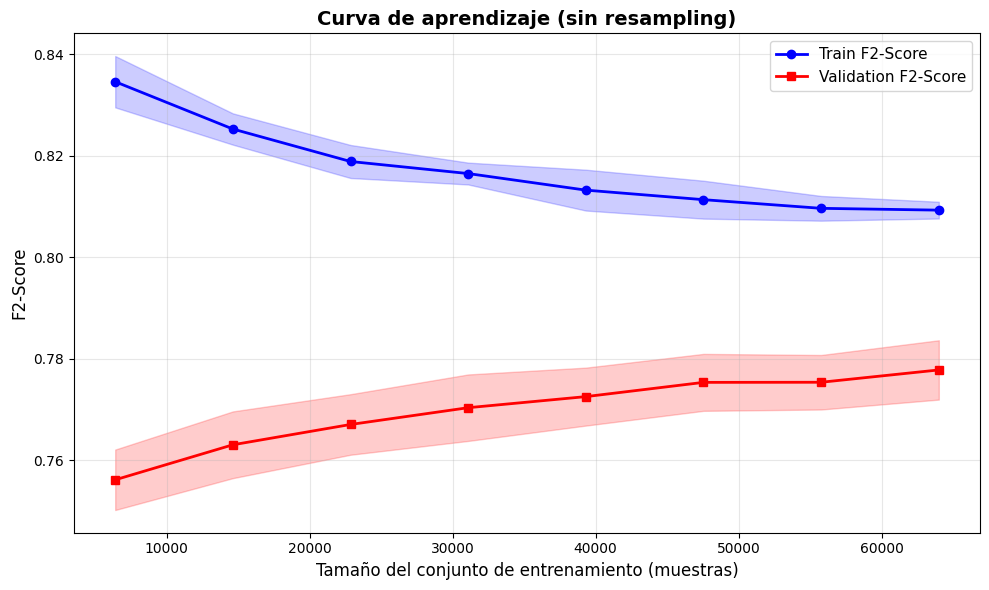


RESUMEN DE LA CURVA DE APRENDIZAJE
Mejor tamaño de entrenamiento: 64000 muestras
Mejor F2-Score en validación: 0.7778 (±0.0058)
F2-Score correspondiente en train: 0.8093


In [10]:
result = learning_curve_with_resampling(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    verbose=True,
    use_tqdm=True
)

In [11]:
best_model.fit(X_train, y_train)

XGBClassifier(alpha=0.006742040731588818, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9864034240486679, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=3.459371333534247e-07, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=7.7397181128257975, learning_rate=0.027347143877563065,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=17, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

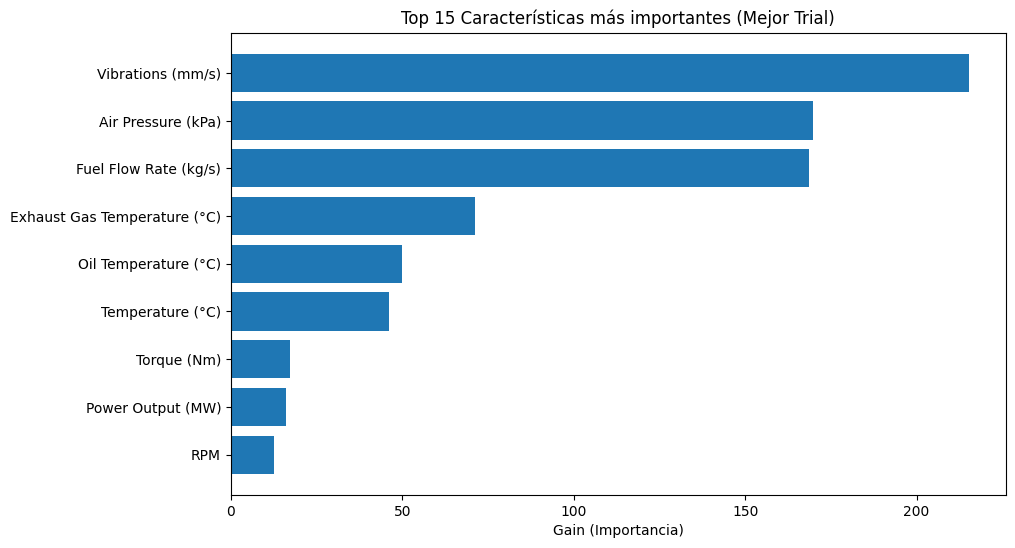

In [12]:
importances = best_model.get_booster().get_score(importance_type='gain')
importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.barh(list(importances.keys())[:15], list(importances.values())[:15]) # Top 15
plt.xlabel("Gain (Importancia)")
plt.title("Top 15 Características más importantes (Mejor Trial)")
plt.gca().invert_yaxis()
plt.show()

In [13]:
test_df = load_split('test', data_dir='dataset/splits')
X_test, y_test = prepare_features_target(test_df, target_col='Fault')

f2_scorer en test: 0.8325665161091195
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     13800
         1.0       0.76      0.78      0.77      6200

    accuracy                           0.85     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.86      0.85      0.85     20000

Matriz de confusión:


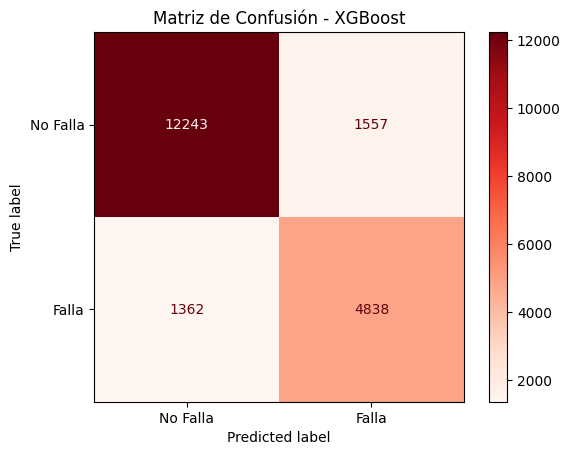

In [14]:
y_pred = best_model.predict(X_test)

print("f2_scorer en test:",
      fbeta_score(y_test, y_pred, beta=2, average="macro"))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
# Plot it using the ConfusionMatrixDisplay imported
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['No Falla', 'Falla'],
                             )
disp.plot(cmap='Reds')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

In [15]:
top_trials = study.trials_dataframe().sort_values("value", ascending=False).head(3)

models_to_combine = []
for i, (idx, row) in enumerate(top_trials.iterrows()):
    params = {k.replace('params_', ''): v for k, v in row.items() if k.startswith('params_')}
    
    m = xgb.XGBClassifier(**params, tree_method="hist")
    models_to_combine.append((f"model_{i}", m))

ensemble = VotingClassifier(estimators=models_to_combine, voting='soft')

Folds CV:   0%|          | 0/5 [00:00<?, ?it/s]


Fold 1/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.8252, Val F2: 0.7678
  Tamaño 14628 -> Train F2: 0.8188, Val F2: 0.7772
  Tamaño 22857 -> Train F2: 0.8152, Val F2: 0.7808
  Tamaño 31085 -> Train F2: 0.8088, Val F2: 0.7822
  Tamaño 39314 -> Train F2: 0.8054, Val F2: 0.7823
  Tamaño 47542 -> Train F2: 0.8034, Val F2: 0.7835
  Tamaño 55771 -> Train F2: 0.8032, Val F2: 0.7848


Folds CV:  20%|██        | 1/5 [00:06<00:24,  6.19s/it]

  Tamaño 64000 -> Train F2: 0.8029, Val F2: 0.7854

Fold 2/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.8357, Val F2: 0.7651
  Tamaño 14628 -> Train F2: 0.8223, Val F2: 0.7736
  Tamaño 22857 -> Train F2: 0.8123, Val F2: 0.7694
  Tamaño 31085 -> Train F2: 0.8120, Val F2: 0.7766
  Tamaño 39314 -> Train F2: 0.8070, Val F2: 0.7786
  Tamaño 47542 -> Train F2: 0.8060, Val F2: 0.7790
  Tamaño 55771 -> Train F2: 0.8039, Val F2: 0.7821


Folds CV:  40%|████      | 2/5 [00:12<00:18,  6.32s/it]

  Tamaño 64000 -> Train F2: 0.8037, Val F2: 0.7835

Fold 3/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.8366, Val F2: 0.7545
  Tamaño 14628 -> Train F2: 0.8256, Val F2: 0.7641
  Tamaño 22857 -> Train F2: 0.8202, Val F2: 0.7642
  Tamaño 31085 -> Train F2: 0.8170, Val F2: 0.7669
  Tamaño 39314 -> Train F2: 0.8122, Val F2: 0.7694
  Tamaño 47542 -> Train F2: 0.8112, Val F2: 0.7709
  Tamaño 55771 -> Train F2: 0.8073, Val F2: 0.7709


Folds CV:  60%|██████    | 3/5 [00:18<00:12,  6.22s/it]

  Tamaño 64000 -> Train F2: 0.8064, Val F2: 0.7713

Fold 4/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.8246, Val F2: 0.7522
  Tamaño 14628 -> Train F2: 0.8139, Val F2: 0.7585
  Tamaño 22857 -> Train F2: 0.8147, Val F2: 0.7649
  Tamaño 31085 -> Train F2: 0.8086, Val F2: 0.7667
  Tamaño 39314 -> Train F2: 0.8074, Val F2: 0.7692
  Tamaño 47542 -> Train F2: 0.8060, Val F2: 0.7690
  Tamaño 55771 -> Train F2: 0.8036, Val F2: 0.7705


Folds CV:  80%|████████  | 4/5 [00:25<00:06,  6.28s/it]

  Tamaño 64000 -> Train F2: 0.8039, Val F2: 0.7724

Fold 5/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Train F2: 0.8248, Val F2: 0.7556
  Tamaño 14628 -> Train F2: 0.8196, Val F2: 0.7690
  Tamaño 22857 -> Train F2: 0.8169, Val F2: 0.7725
  Tamaño 31085 -> Train F2: 0.8137, Val F2: 0.7762
  Tamaño 39314 -> Train F2: 0.8102, Val F2: 0.7790
  Tamaño 47542 -> Train F2: 0.8102, Val F2: 0.7846
  Tamaño 55771 -> Train F2: 0.8058, Val F2: 0.7797


Folds CV: 100%|██████████| 5/5 [00:31<00:00,  6.26s/it]

  Tamaño 64000 -> Train F2: 0.8038, Val F2: 0.7818


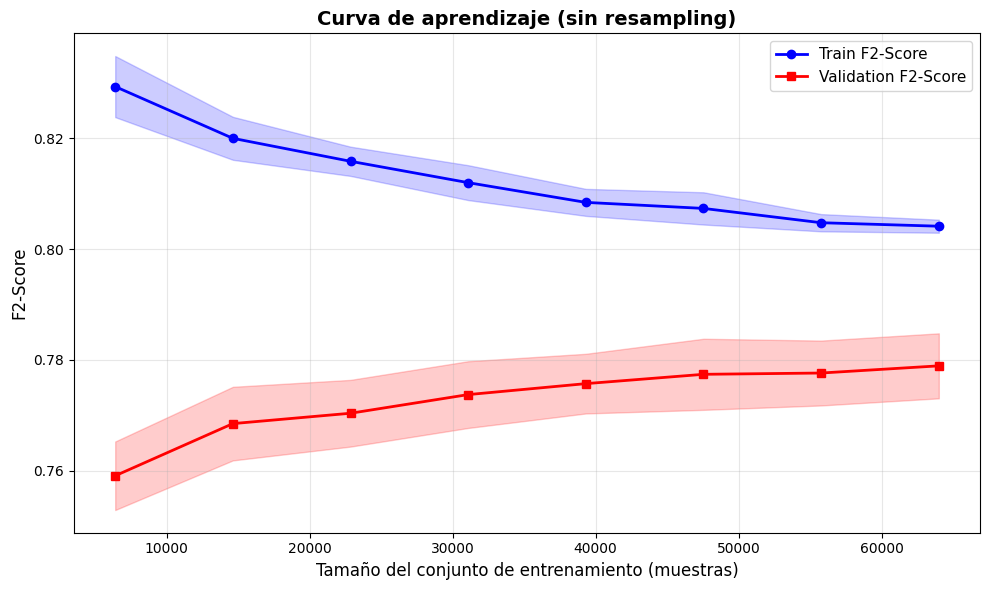


RESUMEN DE LA CURVA DE APRENDIZAJE
Mejor tamaño de entrenamiento: 64000 muestras
Mejor F2-Score en validación: 0.7789 (±0.0059)
F2-Score correspondiente en train: 0.8041


In [16]:
result = learning_curve_with_resampling(
    estimator=ensemble,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    verbose=True,
    use_tqdm=True
)

f2_scorer en test: 0.8336466347752788
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89     13800
         1.0       0.76      0.78      0.77      6200

    accuracy                           0.85     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.86      0.85      0.86     20000

Matriz de confusión:


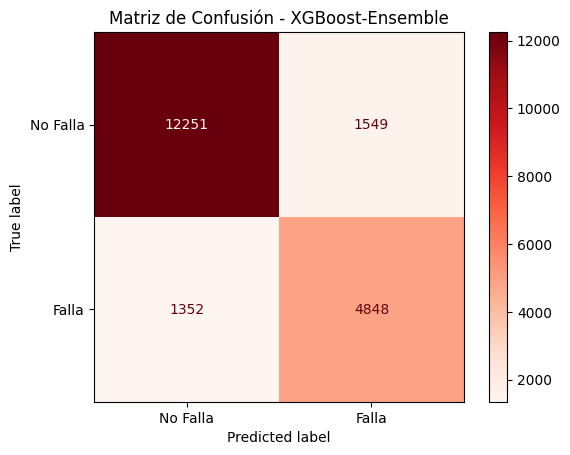

In [17]:
ensemble.fit(X_train, y_train)

final_preds = ensemble.predict(X_test)
print("f2_scorer en test:",
      fbeta_score(y_test, final_preds, beta=2, average="macro"))
print("Reporte de clasificación:")
print(classification_report(y_test, final_preds))
print("Matriz de confusión:")
cm = confusion_matrix(y_test, final_preds)
# Plot it using the ConfusionMatrixDisplay imported
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['No Falla', 'Falla'],
                             )
disp.plot(cmap='Reds')
plt.title('Matriz de Confusión - XGBoost-Ensemble')
plt.show()

In [18]:
paths = save_model(
    model=best_model, 
    model_name='probl1_xgboost',
    save_path='models/',
    metadata={
        'augmented': False,
        'undersampled': False,
        'scaler_applied': False,
        'hyperparameters': best_model.get_params()
    }
)

print(f"Modelo guardado en: {paths['model_path']}")

Modelo guardado en: models/probl1_xgboost_20251222_153103.joblib
